# Gridworld with First Visit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import random
from IPython.display import display, clear_output

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) # total number of actions
gridSize = 5 # create a square grid of gridSize by gridSize
state_count = gridSize*gridSize # total number of states

In [3]:
class Gridworld():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        self.new_pos = [0, 0] # initialize new position for p_transition
        self.transition_prob = 1 # deterministic
    
    def initial_state(self):        # return initial state
        return grid.states[gridSize*gridSize-1]
   
    def transition_reward(self, current_pos, action): # return the transition probability

        # get next position: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_pos = np.array(current_pos) + np.array(action)

        # normally, reward = 0
        reward = 0

        # if new pos results in off the grid, return reward -1
        if -1 in self.new_pos or self.size in self.new_pos:
            reward = -1
        # if in state A, receive + 10
        if current_pos == [0, 1]:
            reward = 10
        # if in state B, receive + 5
        if current_pos == [0, 3]:
            reward = 5

        # if taking an action crosses the border; agent's new_pos is the same as the current pos
        if -1 in self.new_pos or self.size in self.new_pos: 
            self.new_pos = current_pos
            
        # if in state A, transition to state A'
        if current_pos == [0, 1]:
            self.new_pos = [4, 1]
            
        # if in state B, transition to state B'
        if current_pos == [0, 3]:
            self.new_pos = [2, 3]

        return self.new_pos, reward

## Define Functions

In [4]:
def generate_episode(steps):

    # set initial state
    state_vector = grid.initial_state()

    # initialize state (with iniitial state), action list and reward list
    state_list = [state_vector]
    action_list = []
    reward_list = []

    # generate an episode
    for i in range(steps):

        # pick an action based on categorical distribution in policy
        action_index = int(np.random.choice(action_count, 1, p=policy[grid.states.index(state_vector)])) 
        action_vector = actions[action_index] # convert the integer index (ie. 0) to action (ie. [-1, 0])

        # get new state and reward after taking action from current state
        new_state_vector, reward = grid.transition_reward(state_vector, action_vector)
        state_vector = list(new_state_vector)

        # save state, action chosen and reward to list
        state_list.append(state_vector)
        action_list.append(action_vector)
        reward_list.append(reward)
        
    return state_list, action_list, reward_list

In [5]:
# define average function
def Average(lst): 
    return sum(lst) / len(lst) 

## First Visit MC

In [6]:
# create a grid object
grid = Gridworld(5)

# initialize q values for all state action pairs
Q_values = np.zeros((state_count, action_count))

# intialize parameters
gamma = 0.99
epsilon = 0.1

# iterate 500 times: each time, generating an episode of 200 steps
max_steps = 200

# Define lists for plots
average_reward_list = []
cumulative_reward_list = []
cumulative_reward = 0
delta_list = []
episode_test_reward_list = []

In [7]:
# Initiate a random policy
random_policy = np.random.randint(100, size=(state_count, action_count))
random_policy = random_policy/random_policy.sum(axis=1)[:,None]
policy = random_policy

In [8]:
# define variables for keeping track of time steps
Terminal = max_steps
t_list=[]
for i in range(1,max_steps+1):
    t = Terminal - i
    t_list.append(t)

In [9]:
episode_length = 500

# iteration 500 times
for episode in range(episode_length):
  
    # generate an episode of specified step count
    state_list, action_list, reward_list = generate_episode(max_steps)
    
    # calculate average reward of each episode
    average_reward_list.append(Average(reward_list))
    
    # obtain cumulative reward for plotting
    cumulative_reward = cumulative_reward + sum(reward_list)
    cumulative_reward_list.append(cumulative_reward)

    # intialize variables
    G = 0
    delta = 0
    
    # initiate returns and visited list to none
    returns_list = []
    visited_list = []

    # loop for each step of episode: T-1, T-2, T-3 ... 0 = 199, 198, 197 ... 0
    for t in t_list:

        # calculate G: starting with the last reward at index t (naturally accounts for pseudocode's "t-1")
        G = gamma*G + reward_list[t]
        
        # combine state action pair, for example, state = [0,0], action = [0,1], state_action_pair = [0,0,0,1]
        state_action_pair = []
        state_action_pair.extend(state_list[t])
        state_action_pair.extend(action_list[t])

        # check if state action pair have been visited before (if not: continue, else: move to the next time step)
        if state_action_pair not in visited_list:

            # add state action pair to visited list
            visited_list.append(state_action_pair)

            # append G to returns
            returns_list.append(G)

            # find state and action index, for example, converting action [-1, 0] to 0, and same for state #
            state_index = grid.states.index(state_list[t])
            action_index = actions.index(action_list[t])

            # calculate max delta change for plotting max q value change
            delta = max(delta, np.abs(Average(returns_list) - Q_values[state_index][action_index]))      
            
            # write Q_values to the state-action pair
            Q_values[state_index][action_index] = Average(returns_list)

            # choose best action at given state
            choose_action = np.argmax(Q_values[state_index])
            
            # if Q_values is all zero, randomly pick an action
            if np.count_nonzero(Q_values[state_index]) == 0:
                choose_action = random.randint(0,3)

            # overwrite policy
            for a in range(action_count): # for action in actions [0, 1, 2, 3]
                if choose_action == a: # if the choose_action is the same as the current action
                    # policy[state_index][a] = 1 - epsilon 
                    policy[state_index][a] = 1 - epsilon + epsilon/action_count 
                else: # if choose_action is not the same as the current action
                    # policy[state_index][a] = epsilon/3 
                    policy[state_index][a] = epsilon/action_count
     
    # append delta to list
    delta_list.append(delta)
    
    # TEST POLICY after each episode
    # Generate test trajectory with the greedy policy
    state_list, action_list, test_reward_list = generate_episode(200)
    
    # sum up all the rewards obtained during test trajectory and append to list
    episode_test_reward_list.append(sum(test_reward_list))
    
    # print current episode
    clear_output(wait=True)
    display('Episode: ' + str(episode))

'Episode: 499'

## Plots 

In [10]:
window_length = int(episode_length/20)

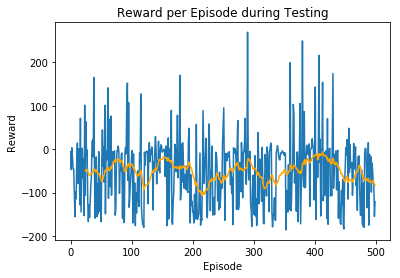

In [11]:
# test reward of each episode
plt.plot(episode_test_reward_list)
plt.title('Reward per Episode during Testing')
plt.xlabel('Episode')
plt.ylabel('Reward')

# plot moving average
delta_frame = pd.DataFrame(episode_test_reward_list)
rolling_mean = delta_frame.rolling(window=window_length).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

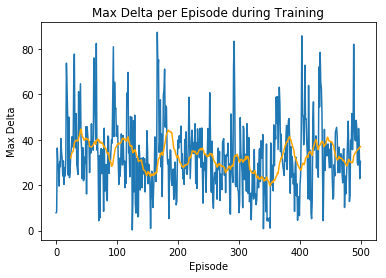

In [12]:
# max delta of each episode, where delta is the change in Q values
plt.plot(delta_list)
plt.title('Max Delta per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Max Delta')

# plot moving average
delta_frame = pd.DataFrame(delta_list)
rolling_mean = delta_frame.rolling(window=window_length).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

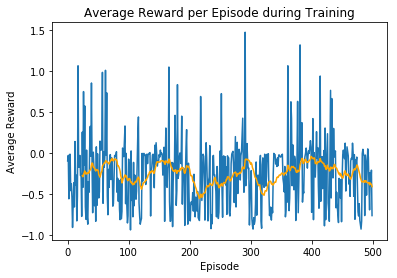

In [13]:
# average reward per episode
plt.plot(average_reward_list)
plt.title('Average Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Average Reward')

# plot moving average
reward_frame = pd.DataFrame(average_reward_list)
rolling_mean = reward_frame.rolling(window=window_length).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')

Text(0, 0.5, 'Cumulative Reward')

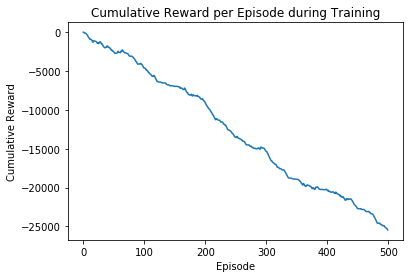

In [14]:
# cumulative reward per episode
plt.plot(cumulative_reward_list)
plt.title('Cumulative Reward per Episode during Training')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')

In [15]:
np.set_printoptions(precision=4)
Q_values

array([[ -4.3628, -25.4393, -27.1625,  -1.    ],
       [-19.6057, -27.1859, -27.5236, -37.4269],
       [-31.4275, -31.2442, -26.987 , -27.1305],
       [  5.    , -33.4902, -17.3625, -39.8424],
       [ -5.74  , -28.3529,  -4.3241, -39.9639],
       [-11.4984, -26.7192, -22.8058, -15.2518],
       [-27.829 , -26.8525,   0.    , -11.1089],
       [-27.0633,  -7.3658,  -1.4891, -29.5889],
       [-17.9725, -11.8689,  -6.6159,   0.    ],
       [ -6.4265,  -1.    , -23.8122, -14.2654],
       [-18.7092, -24.534 , -28.7688, -21.1265],
       [-28.0872,  -1.3173, -21.8057,   0.    ],
       [ -1.5085,  -1.3703,  -1.2359,  -1.2101],
       [-16.5118, -25.5204,  -1.3408,  -1.4605],
       [-13.5054, -26.1022, -21.4169, -25.0134],
       [-26.6703, -28.7687,  -4.2389,  -1.    ],
       [ -1.296 , -28.6416, -16.3029, -18.231 ],
       [ -1.4746, -22.9659, -30.5295, -20.8691],
       [-28.1953, -22.6699, -23.9429, -32.9688],
       [-18.155 , -24.4265, -23.0004, -25.645 ],
       [ -0.995 , -1

In [16]:
policy

array([[0.0333, 0.0333, 0.0333, 0.9   ],
       [0.9   , 0.0333, 0.0333, 0.0333],
       [0.0333, 0.0333, 0.9   , 0.0333],
       [0.9   , 0.0333, 0.0333, 0.0333],
       [0.0333, 0.0333, 0.9   , 0.0333],
       [0.9   , 0.0333, 0.0333, 0.0333],
       [0.0333, 0.0333, 0.9   , 0.0333],
       [0.0333, 0.0333, 0.9   , 0.0333],
       [0.0333, 0.0333, 0.0333, 0.9   ],
       [0.0333, 0.9   , 0.0333, 0.0333],
       [0.9   , 0.0333, 0.0333, 0.0333],
       [0.0333, 0.0333, 0.0333, 0.9   ],
       [0.0333, 0.0333, 0.0333, 0.9   ],
       [0.0333, 0.0333, 0.9   , 0.0333],
       [0.9   , 0.0333, 0.0333, 0.0333],
       [0.0333, 0.0333, 0.0333, 0.9   ],
       [0.9   , 0.0333, 0.0333, 0.0333],
       [0.9   , 0.0333, 0.0333, 0.0333],
       [0.0333, 0.9   , 0.0333, 0.0333],
       [0.9   , 0.0333, 0.0333, 0.0333],
       [0.9   , 0.0333, 0.0333, 0.0333],
       [0.0333, 0.0333, 0.0333, 0.9   ],
       [0.0333, 0.9   , 0.0333, 0.0333],
       [0.0333, 0.0333, 0.0333, 0.9   ],
       [0.9   , 

## Visualize Final Policy

In [17]:
# PRINT POLICY TABLE ################################################################################
# import pandas library
import pandas as pd
# define column and index
columns=range(grid.size)
index = range(grid.size)
# define dataframe to represent policy table
policy_table = pd.DataFrame(index = index, columns=columns)

# iterate through policy to make a table that represents action number
# as action name (eg. left, right, up, down)
for state in range(len(policy)):
    
    # find the best action at each state
    best_action = np.argmax(policy[state])

    # get action name
    if best_action == 0:
        action_name = 'up'
    elif best_action == 1:
        action_name = 'right'
    elif best_action == 2:
        action_name = 'down'
    else:
        action_name = 'left'

    # calculate the row and column coordinate of the current state number
    row = int(state/grid.size)
    column = round((state/grid.size - int(state/grid.size))*grid.size)
            
    # assign action name
    policy_table.loc[row][column] = action_name

print("Policy Table: ")
print(policy_table)
print()

Policy Table: 
      0     1      2      3      4
0  left    up   down     up   down
1    up  down   down   left  right
2    up  left   left   down     up
3  left    up     up  right     up
4    up  left  right   left     up

